**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

**Import necessary libraries**

In [15]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
print(os.listdir("../dataset"))
import warnings
warnings.filterwarnings('ignore')


['.DS_Store', 'IMDB Dataset.csv']


**Import the training dataset**

In [16]:
#importing the training data
imdb_data=pd.read_csv('../dataset/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [17]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


**Sentiment count**

In [18]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [19]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


**Text normalization**

In [20]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

**Removing html strips and noise text**

In [21]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

**Removing special characters**

In [22]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text stemming**

In [23]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Removing stopwords**

In [24]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'now', 'if', 'while', "weren't", 'had', 'down', 'ma', 'herself', 'to', 'mustn', "doesn't", 'a', 'at', 'being', 'should', 'your', 'd', "mightn't", 'own', 'they', 'needn', 'from', 'i', 'each', "isn't", 'no', 'because', 'hasn', 'that', "she's", 'how', 'mightn', 'her', 'below', 'as', 'be', 'both', 'm', "needn't", 've', 'an', 'for', 'here', 'weren', "you'll", 'them', 'am', 'of', "won't", 's', 'yours', 'theirs', 'can', 'you', 'it', 'their', 'which', 'until', "wouldn't", 'any', 't', 'shan', 'such', 'ours', 'having', 'off', 'themselves', 'but', 'will', 'after', 'himself', 'don', 'by', 'in', 'over', 'she', "mustn't", 'again', 'did', 'whom', 'too', "you've", 'those', 'with', 'into', "you're", "hasn't", "wasn't", 'are', 'does', 'my', 'have', 'ain', 'out', "don't", "shan't", 'shouldn', "hadn't", 'or', 'very', 'there', "haven't", 'his', 'yourselves', 'doing', "it's", "didn't", 'under', 'ourselves', 'the', 'were', 'he', 'o', 'few', 'some', 'before', 'up', 'who', 'our', 'above', 'myself', 'do', 'hav

**Normalized train reviews**

In [25]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

**Normalized test reviews**

In [26]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

**Bags of words model **

It is used to convert text documents to numerical vectors or bag of words.

In [27]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6983231)
BOW_cv_test: (10000, 6983231)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [28]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6983231)
Tfidf_test: (10000, 6983231)


**Labeling the sentiment text**

In [29]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


**Split the sentiment tdata**

In [30]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


**Modelling the dataset**

Let us build logistic regression model for both bag of words and tfidf features

In [31]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


**Logistic regression model performane on test dataset**

In [32]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict[:11])
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict[:11])

[0 0 0 0 0 1 1 0 0 0 1]
[0 0 0 0 0 1 1 0 0 0 1]


**Accuracy of the model**

In [33]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8469
lr_tfidf_score : 0.8867


**Print the classification report**

In [34]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.81      0.90      0.85      4993
    Negative       0.89      0.79      0.84      5007

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.89      4993
    Negative       0.88      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**Confusion matrix**

In [35]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3980 1027]
 [ 504 4489]]
[[4459  548]
 [ 585 4408]]


In [36]:
import joblib
 
# Save the logistic regression model for Bag of Words
joblib.dump(lr_bow, 'lr_bow_model.pkl')
 
# Save the logistic regression model for TF-IDF
joblib.dump(lr_tfidf, 'lr_tfidf_model.pkl')

['lr_tfidf_model.pkl']

**Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features**

In [41]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


**Model performance on test data**

In [42]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


**Accuracy of the model**

In [43]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.8433
svm_tfidf_score : 0.8869


**Print the classification report**

In [44]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.80      0.91      0.85      4993
    Negative       0.90      0.77      0.83      5007

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      4993
    Negative       0.88      0.90      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**Plot the confusion matrix**

In [45]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3878 1129]
 [ 438 4555]]
[[4497  510]
 [ 621 4372]]


In [46]:
# Save the SVM model for Bag of Words
joblib.dump(svm_bow, 'svm_bow_model.pkl')
 
# Save the SVM model for TF-IDF
joblib.dump(svm_tfidf, 'svm_tfidf_model.pkl')

['svm_tfidf_model.pkl']

**Multinomial Naive Bayes for bag of words and tfidf features**

In [76]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


**Model performance on test data**

In [77]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


**Accuracy of the model**

In [78]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.8783
mnb_tfidf_score : 0.8892


**Print the classification report**

In [79]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.85      0.91      0.88      4993
    Negative       0.91      0.84      0.87      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

    Positive       0.88      0.90      0.89      4993
    Negative       0.90      0.88      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**Plot the confusion matrix**

In [80]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4218  789]
 [ 428 4565]]
[[4391  616]
 [ 492 4501]]


In [81]:
# Save the MNB model for Bag of Words
joblib.dump(mnb_bow, 'mnb_bow_model.pkl')
 
# Save the MNB model for TF-IDF
joblib.dump(mnb_tfidf, 'mnb_tfidf_model.pkl')

['mnb_tfidf_model.pkl']

**Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

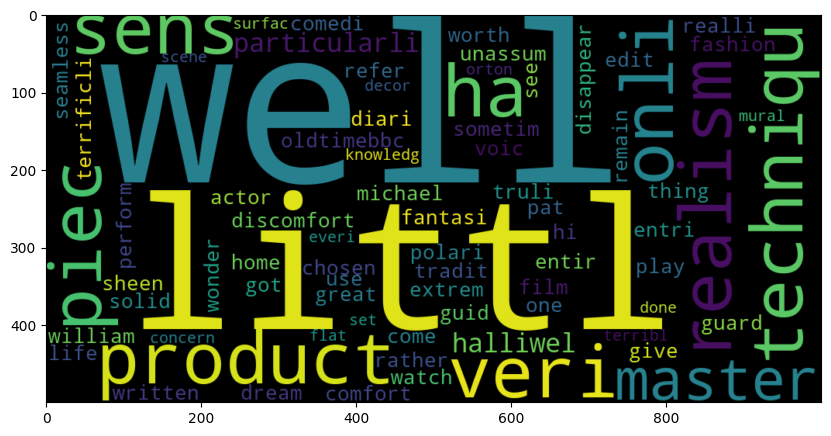

In [33]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

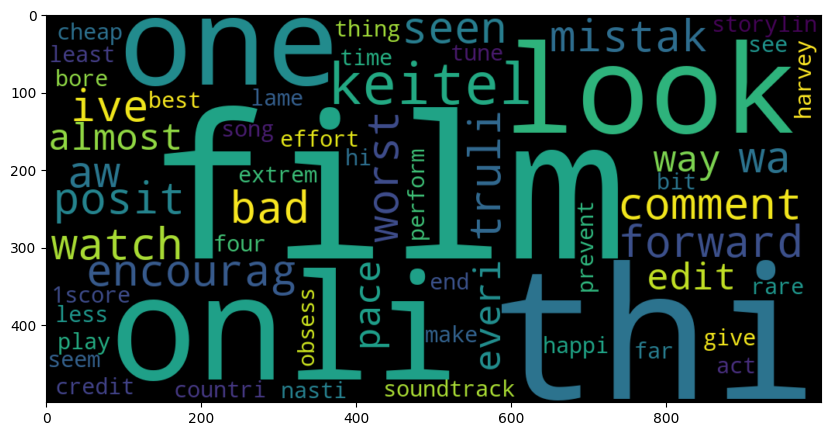

In [34]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

Testing the model

In [62]:
from bs4 import BeautifulSoup

import re

import nltk

from nltk.tokenize.toktok import ToktokTokenizer

from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
 
# Initialize tokenizer and stemmer

tokenizer = ToktokTokenizer()

stemmer = PorterStemmer()
 
# Function to preprocess text

def preprocess(text):

    # Strip HTML tags

    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove text within square brackets

    text = re.sub(r'\[[^]]*\]', '', text)

    # Remove special characters

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Stemming

    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Remove stopwords

    stop_words = set(stopwords.words('english'))

    tokens = tokenizer.tokenize(text)

    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    return ' '.join(filtered_tokens)

In [88]:
# Example review
new_review = " best movie"
 
# Preprocess the review (similar to what you did for training data)
processed_review = preprocess(new_review)
 
# Transform the preprocessed review using the same vectorizer used during training
# Replace cv or tv with the appropriate vectorizer used during training
transformed_review = cv.transform([processed_review])  # for Bag of Words
# Or
transformed_review = tv.transform([processed_review])  # for TF-IDF

In [89]:
# Load the logistic regression model for Bag of Words
lr_bow_model = joblib.load('lr_bow_model.pkl')
 
# Load the logistic regression model for TF-IDF
lr_tfidf_model = joblib.load('lr_tfidf_model.pkl')

In [90]:
# Predict sentiment using the loaded model
predicted_sentiment_bow = lr_bow_model.predict(transformed_review)
predicted_sentiment_tfidf = lr_tfidf_model.predict(transformed_review)
 
# Map the predicted sentiment back to its label (positive/negative)
predicted_sentiment_label_bow = lb.inverse_transform(predicted_sentiment_bow)
predicted_sentiment_label_tfidf = lb.inverse_transform(predicted_sentiment_tfidf)
 
print("Predicted sentiment by LR (Bag of Words):", predicted_sentiment_label_bow[0])
print("Predicted sentiment by LR (TF-IDF):", predicted_sentiment_label_tfidf[0])

Predicted sentiment by LR (Bag of Words): positive
Predicted sentiment by LR (TF-IDF): positive


In [91]:
# Load the SVM model for Bag of Words
svm_bow_model = joblib.load('svm_bow_model.pkl')
 
# Load the SVM model for TF-IDF
svm_tfidf_model = joblib.load('svm_tfidf_model.pkl')

In [92]:
# Predict sentiment using the loaded model
predicted_sentiment_bow = svm_bow_model.predict(transformed_review)
predicted_sentiment_tfidf = svm_tfidf_model.predict(transformed_review)
 
# Map the predicted sentiment back to its label (positive/negative)
predicted_sentiment_label_bow = lb.inverse_transform(predicted_sentiment_bow)
predicted_sentiment_label_tfidf = lb.inverse_transform(predicted_sentiment_tfidf)
 
print("Predicted sentiment by SVM (Bag of Words):", predicted_sentiment_label_bow[0])
print("Predicted sentiment by SVM (TF-IDF):", predicted_sentiment_label_tfidf[0])

Predicted sentiment by SVM (Bag of Words): positive
Predicted sentiment by SVM (TF-IDF): positive


In [93]:
# Load the SVM model for Bag of Words
mnb_bow_model = joblib.load('svm_bow_model.pkl')
 
# Load the SVM model for TF-IDF
mnb_tfidf_model = joblib.load('svm_tfidf_model.pkl')

In [94]:
# Predict sentiment using the loaded model
predicted_sentiment_bow = mnb_bow_model.predict(transformed_review)
predicted_sentiment_tfidf = mnb_tfidf_model.predict(transformed_review)
 
# Map the predicted sentiment back to its label (positive/negative)
predicted_sentiment_label_bow = lb.inverse_transform(predicted_sentiment_bow)
predicted_sentiment_label_tfidf = lb.inverse_transform(predicted_sentiment_tfidf)
 
print("Predicted sentiment by MNB (Bag of Words):", predicted_sentiment_label_bow[0])
print("Predicted sentiment by MNB (TF-IDF):", predicted_sentiment_label_tfidf[0])

Predicted sentiment by MNB (Bag of Words): positive
Predicted sentiment by MNB (TF-IDF): positive


**Conclusion:**
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines.
* Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.